In [3]:
import os
import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import mediapipe as mp
from sklearn.model_selection import train_test_split

In [4]:
def read_image(filename):
        label = int(filename[filename.rindex('_') + 1])
        img = cv2.imread(filename, 1)
        return img, label
    
    
def read_images(img_dir, cache_on=True):
    cache = os.path.join(img_dir, 'data.npz')
    if cache_on and os.path.exists(cache):
        with open(cache, 'rb') as f:
            data = np.load(f)
            return data['arr_0'], data['arr_1']

    X, y = [], []
    for filename in os.listdir(img_dir):
        if os.path.splitext(filename)[1] != '.png':
            continue
        img, label = read_image(os.path.join(img_dir, filename))
        X.append(img)
        y.append(label)
        
    X = np.array(X)
    y = np.array(y)

#     X = X.reshape(*X.shape, 1).astype(np.float16)

    if cache_on:
        np.savez(cache, X, y)

    return X, y
            
    
def load_data(data_dir, cache_on=True):
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    return read_images(train_dir, cache_on), read_images(test_dir, cache_on)

In [5]:
(Xtrain, ytrain), (Xtest, ytest) = load_data('images_reduced')

In [6]:
Xtrain.shape, Xtrain.dtype, ytrain.shape, ytrain.dtype

((3000, 128, 128, 1), dtype('float16'), (3000,), dtype('int64'))

In [7]:
Xtest.shape, Xtest.dtype, ytest.shape, ytest.dtype

((600, 128, 128, 1), dtype('float16'), (600,), dtype('int64'))

In [8]:
X, y = Xtrain, ytrain
Xreduced = np.empty((0, *X.shape[1:]), dtype=X.dtype)
yreduced = np.empty((0, *y.shape[1:]), dtype=y.dtype)
m = 500
for i in range(6):
    x = X[y == i]
    yreduced = np.append(yreduced, np.full(m, i))
    Xreduced = np.append(Xreduced, x[np.random.choice(len(x), m, replace=False)], axis=0)
np.savez('images_reduced/train/data.npz', Xreduced, yreduced)

In [9]:
Counter(ytrain), Counter(ytest)

(Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500}),
 Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}))

In [10]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [ ]:
with mp_hands.Hands(static_image_mode=True) as hands:
    count, count_all = 0, 0
    for filename in glob.glob('images/test/*.png'):
        count_all += 1
        print('\r' + str(count_all), end='')
        image = cv2.imread(filename)
        image += np.array([30, 0, 0], dtype=np.uint8)
        results = hands.process(image)
        if results.multi_hand_landmarks:
            count += 1
            cv2.imwrite(filename.replace('images/test', 'images_colored/test'), image)
            for hand_landmark in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmark,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style(),
                )
        
    print(count, count_all)

1

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


24

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



25Traceback (most recent call last):
  File "/home/me/miniconda3/envs/dsml2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_192138/2904428780.py", line 6, in <module>
    image = cv2.imread(filename)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/me/miniconda3/envs/dsml2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/me/miniconda3/envs/dsml2/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home

ERROR! Session/line number was not unique in database. History logging moved to new session 100


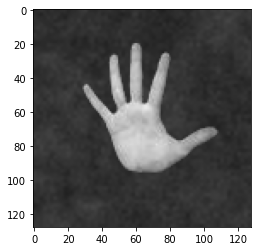

In [11]:
with mp_hands.Hands(static_image_mode=True) as hands:
#     image = cv2.cvtColor(cv2.imread('test.png'), cv2.COLOR_BGR2RGB)
#     image = cv2.cvtColor(cv2.imread('output.jpg'), cv2.COLOR_BGR2RGB)
    image = cv2.imread('test5.png')
#     image += np.array([30, 0, 0], dtype=np.uint8)
    results = hands.process(image)
    if results.multi_hand_landmarks:
        for hand_landmark in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image,
                hand_landmark,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style(),
            )
    plt.imshow(image)

In [12]:
X, y = read_images('images_colored/test')
Counter(y)

Counter({4: 570, 0: 575, 1: 506, 5: 561, 2: 450, 3: 415})

In [13]:
def extract_features(image):
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(static_image_mode=True) as hands:
        results = hands.process(image)
        hand_landmark = results.multi_hand_world_landmarks[0]
        features = []
        for v in hand_landmark.landmark:
            features.append(v.x)
            features.append(v.y)
        
        return features

In [14]:
with mp_hands.Hands(static_image_mode=True) as hands:
    data = []
    for image in X:
#         plt.imshow(image)
        results = hands.process(image)
        hand_landmark = results.multi_hand_world_landmarks[0]
        features = []
        for v in hand_landmark.landmark:
            features.append(v.x)
            features.append(v.y)
            
        data.append(features)
    
    data = np.array(data)
    print(data.shape)

(3077, 42)


In [15]:
data.shape

(3077, 42)

In [16]:
np.savez('mediapipe-data', data, y)

In [17]:
loaded = np.load('mediapipe-data.npz')

In [18]:
X, y = loaded['arr_0'], loaded['arr_1']

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [20]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(6, activation='softmax'),
])

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=50)

Train on 2307 samples, validate on 770 samples
Epoch 1/50
2307/2307 [==============================] - 1s 381us/sample - loss: 0.2795 - accuracy: 0.9319 - val_loss: 0.3073 - val_accuracy: 0.9208
Epoch 2/50
2307/2307 [==============================] - 1s 425us/sample - loss: 0.2746 - accuracy: 0.9350 - val_loss: 0.3027 - val_accuracy: 0.9221
Epoch 3/50
2307/2307 [==============================] - 1s 320us/sample - loss: 0.2697 - accuracy: 0.9354 - val_loss: 0.2993 - val_accuracy: 0.9195
Epoch 4/50
2307/2307 [==============================] - 1s 398us/sample - loss: 0.2655 - accuracy: 0.9337 - val_loss: 0.2956 - val_accuracy: 0.9195
Epoch 5/50
2307/2307 [==============================] - 1s 444us/sample - loss: 0.2612 - accuracy: 0.9345 - val_loss: 0.2915 - val_accuracy: 0.9208
Epoch 6/50
2307/2307 [==============================] - 1s 609us/sample - loss: 0.2573 - accuracy: 0.9345 - val_loss: 0.2879 - val_accuracy: 0.9221
Epoch 7/50
2307/2307 [==============================] - 1s 391us/

In [24]:
df = pd.DataFrame(history.history)

<AxesSubplot:>

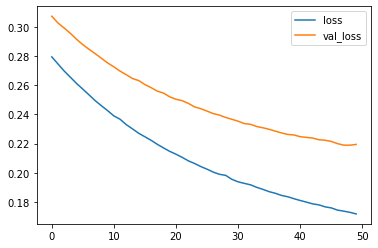

In [25]:
df[['loss', 'val_loss']].plot()

(3077, 42)

In [12]:
model.predict(np.expand_dims(Xtest[5], axis=0)).argmax()

0

In [26]:
model.save(os.path.join('models', 'dummy-model'))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


2022-02-28 07:13:20.356341: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: models/dummy-model/assets


INFO:tensorflow:Assets written to: models/dummy-model/assets


In [ ]:
loaded = keras.models.load_model(os.path.join('models', 'dummy-model'))

In [ ]:
n = 5
loaded.predict(np.expand_dims(Xtest[n], axis=0)).argmax(), ytest[n]

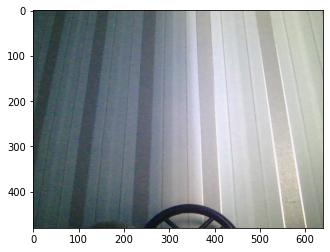

In [80]:
source = cv2.VideoCapture(0)
_, frame = source.read()
plt.imshow(frame)
source.release()

In [ ]:
frame.shape

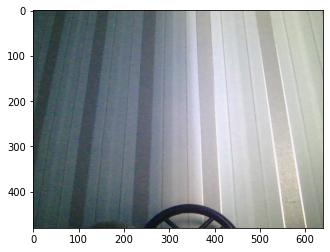

In [83]:
bframe = cv2.imread('background.png', 1)
plt.imshow(bframe)

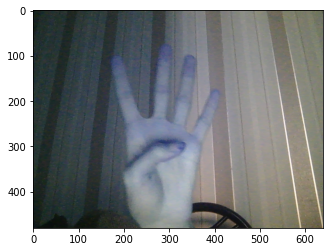

In [57]:
fframe = cv2.imread('test.png', 1)
plt.imshow(fframe)

In [67]:
model.predict(np.array([extract_features(fframe)])).argmax()

2

In [81]:
cv2.imwrite('background.png', frame)

True

In [85]:
def process_frame(pframe, fgbg=cv2.createBackgroundSubtractorMOG2()):
    pframe = cv2.resize(pframe, (128, 128))
    pframe = fgbg.apply(pframe)
    return pframe

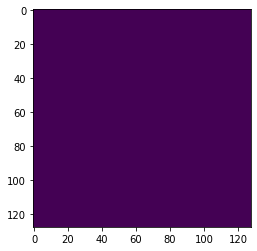

In [58]:
plt.imshow(process_frame(frame))

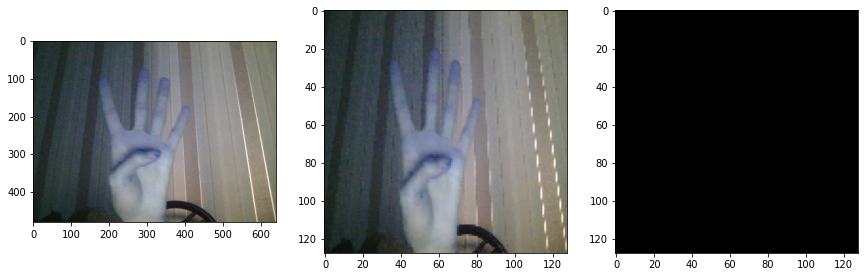

In [97]:
frame = fframe

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(frame)

plt.subplot(1, 4, 2)
plt.imshow(cv2.resize(frame, (128, 128)))

plt.subplot(1, 4, 3)
plt.imshow(process_frame(frame), cmap='gray')

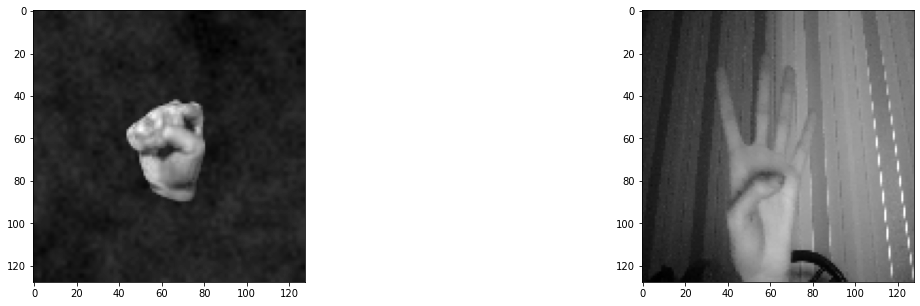

In [28]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.imshow(Xtrain[2].astype(np.int32), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(rgframe, cmap='gray')

In [27]:
model.predict(np.expand_dims(rgframe.reshape(*rgframe.shape, 1), axis=0))

array([[1., 0., 0., 0., 0., 0.]], dtype=float32)